In [6]:
import nibabel as nib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [4]:
cd D:\Program\data\AOCR2024\mask_bundle

D:\Program\data\AOCR2024\mask_bundle


試畫mask


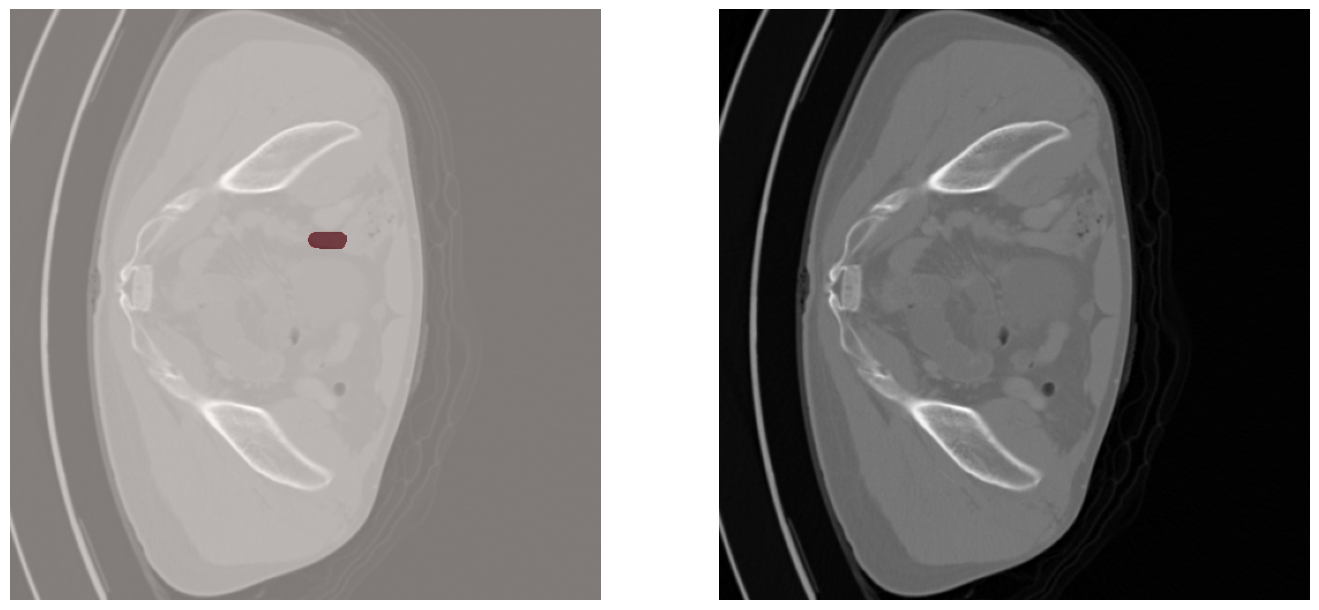

In [7]:

# 读取nii文件
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii')
mydata = nii_file.get_fdata()
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628_label.nii')
mymask = nii_file.get_fdata()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,20)
plt.subplots_adjust(left=0.25, bottom=0.25)
current_slice = 27

axs[0].imshow(mydata[:, :, current_slice], cmap='gray')
axs[0].imshow(mymask[:, :, current_slice], cmap='Reds', alpha=0.5)
axs[1].imshow(mydata[:, :, current_slice], cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()